In [107]:
%matplotlib inline
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from nltk.stem.porter import PorterStemmer

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [108]:
def detect_lang(comment):
    
    language = "No found"
    try:
        language = detect(comment)
    except:
        print "could not find language"
    return language

In [109]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('data/reviews.csv')
    
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("data/reviews_with_lang.csv")
    

In [110]:
df_reviews = pd.read_csv('data/reviews_with_lang.csv')
df_reviews_eng = df_reviews[df_reviews.language=='en']

df_listing = pd.read_csv('data/listings.csv')


In [111]:
df_listing.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

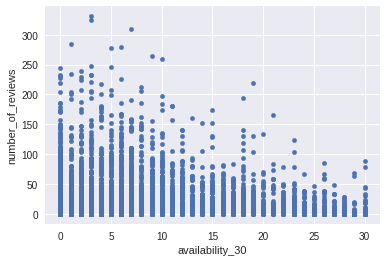

In [112]:
df_listing[df_listing.room_type=='Entire home/apt'].plot(kind='scatter',x='availability_30',y='number_of_reviews')

In [113]:
df_listing.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [114]:
df_reviews_eng = pd.merge(df_reviews_eng,df_listing[['id','review_scores_rating','review_scores_cleanliness','room_type','availability_30']],left_on='listing_id',right_on='id')

In [115]:
df_reviews_eng.head()

,Unnamed: 0,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,id_y,review_scores_rating,review_scores_cleanliness,room_type,availability_30
0,1,7878281,50115386,2015-10-09,45018962,Rotem,"AMAZING hosting, we arrived to Benita's appart...",en,7878281,99.0,10.0,Entire home/apt,6
1,3,7878281,58376102,2016-01-02,6789115,Nicola,"This apartment was beautiful, spacious, warm a...",en,7878281,99.0,10.0,Entire home/apt,6
2,4,7878281,71814574,2016-04-28,63494941,Claudio,BENITA AND KLEMENS WERE VERY KIND WITH US. THE...,en,7878281,99.0,10.0,Entire home/apt,6
3,5,7878281,74568125,2016-05-15,57750113,Sandeep,Yes. Klemens came with a bouquet of flowers an...,en,7878281,99.0,10.0,Entire home/apt,6
4,7,7878281,86698077,2016-07-17,19899121,Brian,Great experience. Hosts were responsive and fr...,en,7878281,99.0,10.0,Entire home/apt,6


In [116]:
groupy = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

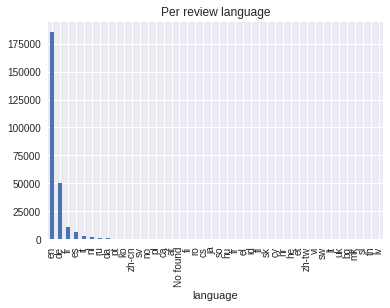

In [117]:
groupy.plot.bar(title="Per review language")

In [120]:
def concat_comments(x):
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews_eng[df_reviews_eng.room_type=='Entire home/apt']
df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]
groupy = df_reviews_eng.groupby('listing_id').agg({'comments': concat_comments, 'review_scores_rating': 'mean', 'availability_30':'mean'})
#groupy  = df_rewiews_eng.groupby('listing_id')['comments','review_scores_cleanliness'].apply(lambda x: "%s" % ', '.join(x))
raw_text = groupy.comments.values

In [121]:
groupy.head()

,review_scores_rating,availability_30,comments
listing_id,,,
1971,96.0,30,great location and out look over the spree flu...
2015,90.0,7,Jan was very friendly and welcoming host! The ...
3176,92.0,0,"excellent stay, i would highly recommend it. a..."
9991,100.0,4,The host was very welcoming and hospitable. He...
11203,100.0,3,He was a kind and polite gentleman.\r\n\r\nThe...


In [46]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


def get_vectorized_text(X,ngram_range=(1,1),max_features=None):
    pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=ngram_range,tokenizer=tokenizer_porter,stop_words=stop,max_features=max_features)),
                         ('tfidf', TfidfTransformer())]) 
    return pipeline.fit_transform(X).todense()

X_vectorized = get_vectorized_text(raw_text,ngram_range=(2,3),max_features=2000)
pca = PCA(n_components=2).fit(X_vectorized)

print pca.explained_variance_ratio_.sum()
print pca.explained_variance_ratio_*100

[nltk_data] Downloading package stopwords to /home/ramon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0.0242697357188
[ 1.67435628  0.7526173 ]


In [47]:
data2D = pca.transform(X_vectorized)
groupy['pc1']=data2D[:,0]
groupy['pc2']=data2D[:,1]

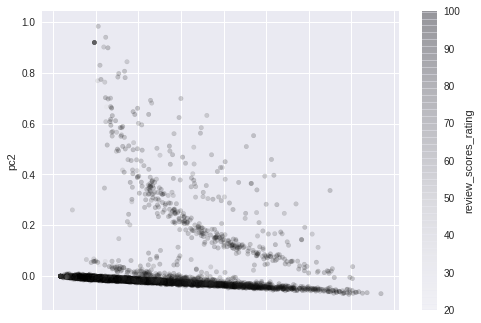

In [48]:
cmap = cm.get_cmap('Spectral')
data2D = pca.transform(X_vectorized)
groupy.plot(kind='scatter',x='pc1', y='pc2',c='review_scores_rating',alpha=.2)

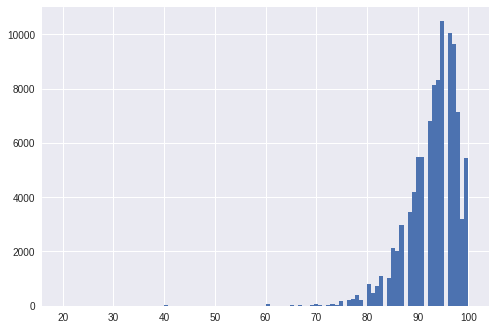

In [67]:
df_reviews_eng.review_scores_rating.hist(bins=100)

In [76]:
groupy['score_cat']=groupy.review_scores_rating.astype(str)
groupy['dirty']= groupy.comments.str.contains('agressive')*1.0

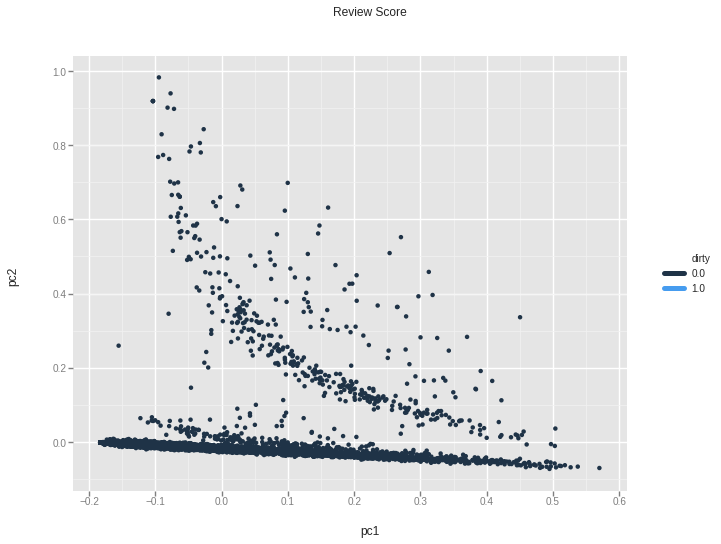

<ggplot: (8764783540009)>

In [77]:
ggplot(groupy, aes(x='pc1', y='pc2', color='dirty')) +\
    geom_point() +\
    xlab("pc1") + ylab("pc2") + ggtitle("Review Score")

In [68]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(raw_text)

In [73]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_vectorized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :100]:
        print ' %s' % terms[ind],
    print

Top terms per cluster:
Cluster 0:  alena  ain  16year  45u  alan  alejsandra  57  acorded  addressed  aday  90m²  42km  aids  alfonss  activating  alcoholic  agter  165  airdbnb  aigul  aida  agreeing  5ms  37  affairs  79ºc  30min  aileen  7minutes  40  alices  73  accimmodating  56k  adaptable  airprot  2walking  additionnal  7h40  ai  a100  2hrs  aeropress  acomodate  ahead  700m  alesso  ak  alexanderplaze  81  alexaderplatz  aleksandrplatz  acceptance  albtau  alexandrplatz  abike44  3min  3people  0930  adapter  70th  absolutely  12c  aircon  accomplished  aggravated  aaked  50euro  activists  airless  airline  6am  alfredo  adressed  38  75th  8h  adrea  absolute  alexandria  accesible  airbnb  acceses  17th  airbnbner  alima  aboit  40pm  109  3children  advances  alacena  711  248  2106  15am  acordamos  750m  10mt  48hr
Cluster 1:  alena  16year  ain  alfonss  alan  addressed  90m²  aeropress  agreeing  57  alejsandra  42km  alcoholic  0930  45u  acorded  accimmodating  agter

In [138]:
count_vectorizer = TfidfVectorizer(ngram_range=(2,2),tokenizer=tokenizer_porter,stop_words=stop,max_features=3000)
counts = count_vectorizer.fit_transform(raw_text)

In [139]:
print raw_text.shape
counts.shape

(7541,)


(7541, 3000)

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
lm = LinearRegression()
rf = RandomForestClassifier()
rf.fit(counts,groupy.availability_30)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [146]:
prediction= rf.predict(counts)

In [148]:
idf = count_vectorizer.idf_
print dict(zip(count_vectorizer.get_feature_names(), idf))

{u'- nice': 3.3041774500184089, u'nice locat': 4.0201597396493716, u'great recommend': 4.7634567038947884, u'7 minut': 5.1833105494550527, u'travel around': 4.8283762499941041, u'locat good,': 5.1160583224458849, u'live berlin': 5.2554138433563962, u'apart even': 4.5165966259632624, u'larg group': 5.6797474357689435, u'like wa': 4.8162548894617592, u'everyth one': 4.3948531890907816, u'thing wa': 4.3335312982164638, u'three night': 4.8283762499941041, u'wa comfort': 3.8013734937041175, u'perfect. apart': 5.200854859105962, u'alexand platz': 4.697134060963716, u"we'll definit": 4.9866002552089981, u'helpful. highli': 5.2554138433563962, u'thi hous': 5.0155877920822505, u'neighborhood close': 5.0999289405160013, u'work fine.': 5.3032698645340313, u'veri safe': 4.2970308959969366, u'stay here!': 4.1444174954885646, u'location, nice': 4.9584293782423021, u'great. wa': 5.0607082273627197, u'nice stay': 3.3406926629935065, u'15 minut': 4.0039868804037706, u'commun veri': 4.4107897813535946, 

In [147]:
r2_score(prediction,groupy.availability_30.values)

0.86609200717277834